In [1]:
import cv2
from time import time
import numpy as np
import matplotlib.pyplot as plt

In [71]:
def displayVertex(src, vertex, mode = 'run'):
    # 展示有效vertex的Demo

    # 读取视频
    cap = cv2.VideoCapture(src)

    # 创建随机颜色
    color = np.random.randint(0, 255, (3000, 3))

    # 获取第一帧，找到角点
    ret, old_frame = cap.read()

    # 获取图像中的角点，返回到p0中
    p0 = vertex[0].reshape(-1, 1, 2)

    # 创建一个蒙版用来画轨迹
    mask = np.zeros_like(old_frame)

    count = 1

    while(1):
        ret, frame = cap.read()
        if type(frame) is type(None):
            break

        # 计算光流
        p1 = vertex[count].reshape(-1, 1, 2)
        count += 1

        flag = ((np.sum(p0, axis = 2) >= 0) & (np.sum(p1, axis = 2) >= 0)).flatten()
        good_old = p0[flag]
        good_new = p1[flag]

        # 画出轨迹
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel().astype('int')
            c, d = old.ravel().astype('int')
            mask = cv2.line(mask, (a, b), (c, d), color[i].tolist(), 2)
            frame = cv2.circle(frame, (a, b), 5, color[i].tolist(), -1)
        img = cv2.add(frame, mask)

        # 展示
        cv2.imshow('frame', img)
        # cv2.imshow('frame_gray', frame_gray)
        k = cv2.waitKey(mode == 'run') & 0xff
        if k == 27:
            break

        # 更新上一帧的图像和追踪点
        p0 = p1

    cv2.destroyAllWindows()
    cap.release()

def orbFeature(img):
    '''
    输入彩色图像，输出屏蔽噪音的特征点
    '''
    orb = cv2.ORB_create(nfeatures = 300, scaleFactor = 2, firstLevel = 0)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # ret, mask1 = cv2.threshold(frame_hsv[..., 2], 100, 255, cv2.THRESH_BINARY_INV)
    ret, mask = cv2.threshold(img_hsv[..., 1], 80, 255, cv2.THRESH_BINARY)
    # mask_hsv = cv2.bitwise_or(mask1, mask2)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    mask = cv2.dilate(mask, kernel, iterations = 1)

    # gray = cv2.medianBlur(gray, 21)
    gray = sharpen(gray)
    gray = cv2.equalizeHist(gray)
    keypoints, _ = orb.detectAndCompute(gray, mask = mask)
    ps = np.array([keypoint.pt for keypoint in keypoints]).reshape(-1, 1, 2).astype('float32')

    return ps

def appendVertex(p0, p_add, min_dis):
    '''
    根据4邻域距离加入新的角点
    '''
    p_ret = p0.copy()
    for p in p_add:
        vec = p0 - p
        dis = abs(vec[:, 0, 0]) + abs(vec[:, 0, 1])
        if all(dis > min_dis):
            p_ret = np.vstack((p_ret, p.reshape(-1, 1, 2)))
    
    add_num = p_ret.shape[0] - p0.shape[0]

    return p_ret, add_num


def sharpen(img):
    '''
    锐化图像
    '''
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], np.float32) #定义一个核
    sharpened = cv2.filter2D(img, -1, kernel=kernel)

    return sharpened

In [72]:
def findVertex(src):
    '''
    利用orb找特征点，利用稀疏光流跟踪找出背景角点，背景角点的特
    征的是移动缓慢，当角点速度小于阈值的时
    间大于200帧时即视为背景角点，并允许中间
    帧加入的角点，速度较慢。

    :param src  : 视频地址
    :type src   : String
    :returns    : 留存时间大于200的角点，
                  格式为(frame_num, p_num, 2)
                  若当前帧没有该角点，
                  则补充[-1, -1]
    '''
    start = time()

    # 读取视频
    cap = cv2.VideoCapture(src)

    # ShiTomasi 角点检测参数
    feature_params = dict(maxCorners=1000,
                            qualityLevel=0.3,
                            minDistance=20,
                            blockSize=7)

    # lucas kanade光流法参数
    lk_params = dict(winSize=(15, 15),
                        maxLevel=2,
                        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # 创建随机颜色
    color = np.random.randint(0, 255, (3000, 3))

    # for i in range(0):
    #     _, _ = cap.read()

    # 获取第一帧，找到角点
    ret, old_frame = cap.read()

    # 找到原始灰度图
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    old_gray = sharpen(old_gray)
    old_gray = cv2.equalizeHist(old_gray)

    # # 获取图像中的角点，返回到p0中
    # p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

    p0 = orbFeature(old_frame)

    # 创建一个蒙版用来画轨迹
    mask = np.zeros_like(old_frame)

    flags = [np.ones(len(p0))]  # 选取的角点标号
    ps = [p0[:,0]] # 保存角点
    out_indexs = np.array([]) # 中途超速的点索引

    while(1):
        ret, frame = cap.read()
        if type(frame) is type(None):
            break
        # frame = frame[332: ,718:, :]
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame_gray = sharpen(frame_gray)
        frame_gray = cv2.equalizeHist(frame_gray)

        # 计算光流
        p1, st, err = cv2.calcOpticalFlowPyrLK(
            old_gray, frame_gray, p0, None, **lk_params)

        # 寻找移动小于5的跟踪点
        movement = p1 - p0
        mag, ang = cv2.cartToPolar(movement[..., 0], movement[..., 1])

        # 选取好的跟踪点
        index = (st == 1) & (mag < 5)
        flag = np.zeros_like(flags[-1])
        flag[np.where(flags[-1] == 1)[0][index.flatten()]] = 1

        good_new = p1[index]
        good_old = p0[index]

        # 若有点速度大于阈值，则将其过去痕迹也抹去
        out_index = np.where(flags[-1] == 1)[0][((st == 1) & (mag >= 5)).flatten()]
        out_indexs = np.append(out_indexs, out_index)

        # 画出轨迹
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(mask, (a, b), (c, d), color[i].tolist(), 2)
            frame = cv2.circle(frame, (a, b), 5, color[i].tolist(), -1)
        img = cv2.add(frame, mask)

        # 展示
        cv2.imshow('frame', img)
        # cv2.imshow('frame_gray', frame_gray)
        k = cv2.waitKey(1) & 0xff
        if k == 27:
            break

        # 更新上一帧的图像和追踪点
        old_gray = frame_gray.copy()
        # p_add = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
        p_add = orbFeature(frame)
        p0 = good_new.reshape(-1, 1, 2)
        p0, add_num = appendVertex(p0, p_add, feature_params['minDistance'] / 1.414)
        flag = np.append(flag, np.ones(add_num))
        flags.append(flag.astype('int'))
        ps.append(p0[:, 0])

    cv2.destroyAllWindows()
    cap.release()

    # -----------将留存时间不够长的的点去掉------------

    # 最小留存时间
    min_duration = 50

    # 统计每个点的留存时间
    duration = np.zeros(flags[-1].shape)
    for flag in flags:
        duration[np.where(flag == 1)[0]] += 1

    # 将有效角点对应起来，若当前帧没有该角点，补充为[-1, -1]
    valid_index = np.where(duration > min_duration)[0]
    valid_index = np.array([index for index in valid_index if index not in out_indexs])

    bg_ps = []
    junk_p = np.array([-1, -1], dtype = 'int')
    for flag, p in zip(flags, ps):
        bg_p = []
        for index in valid_index:
            try:
                if flag[index] == 0:
                    bg_p.append(junk_p)
                else:
                    bg_p.append(p[int(sum(flag[: index]))])
            except:
                bg_p.append(junk_p)

        bg_ps.append(bg_p)

    bg_ps = np.asarray(bg_ps)
    print('vertex find complete in ', time() - start)
    return bg_ps

vertex find complete in  45.07868790626526


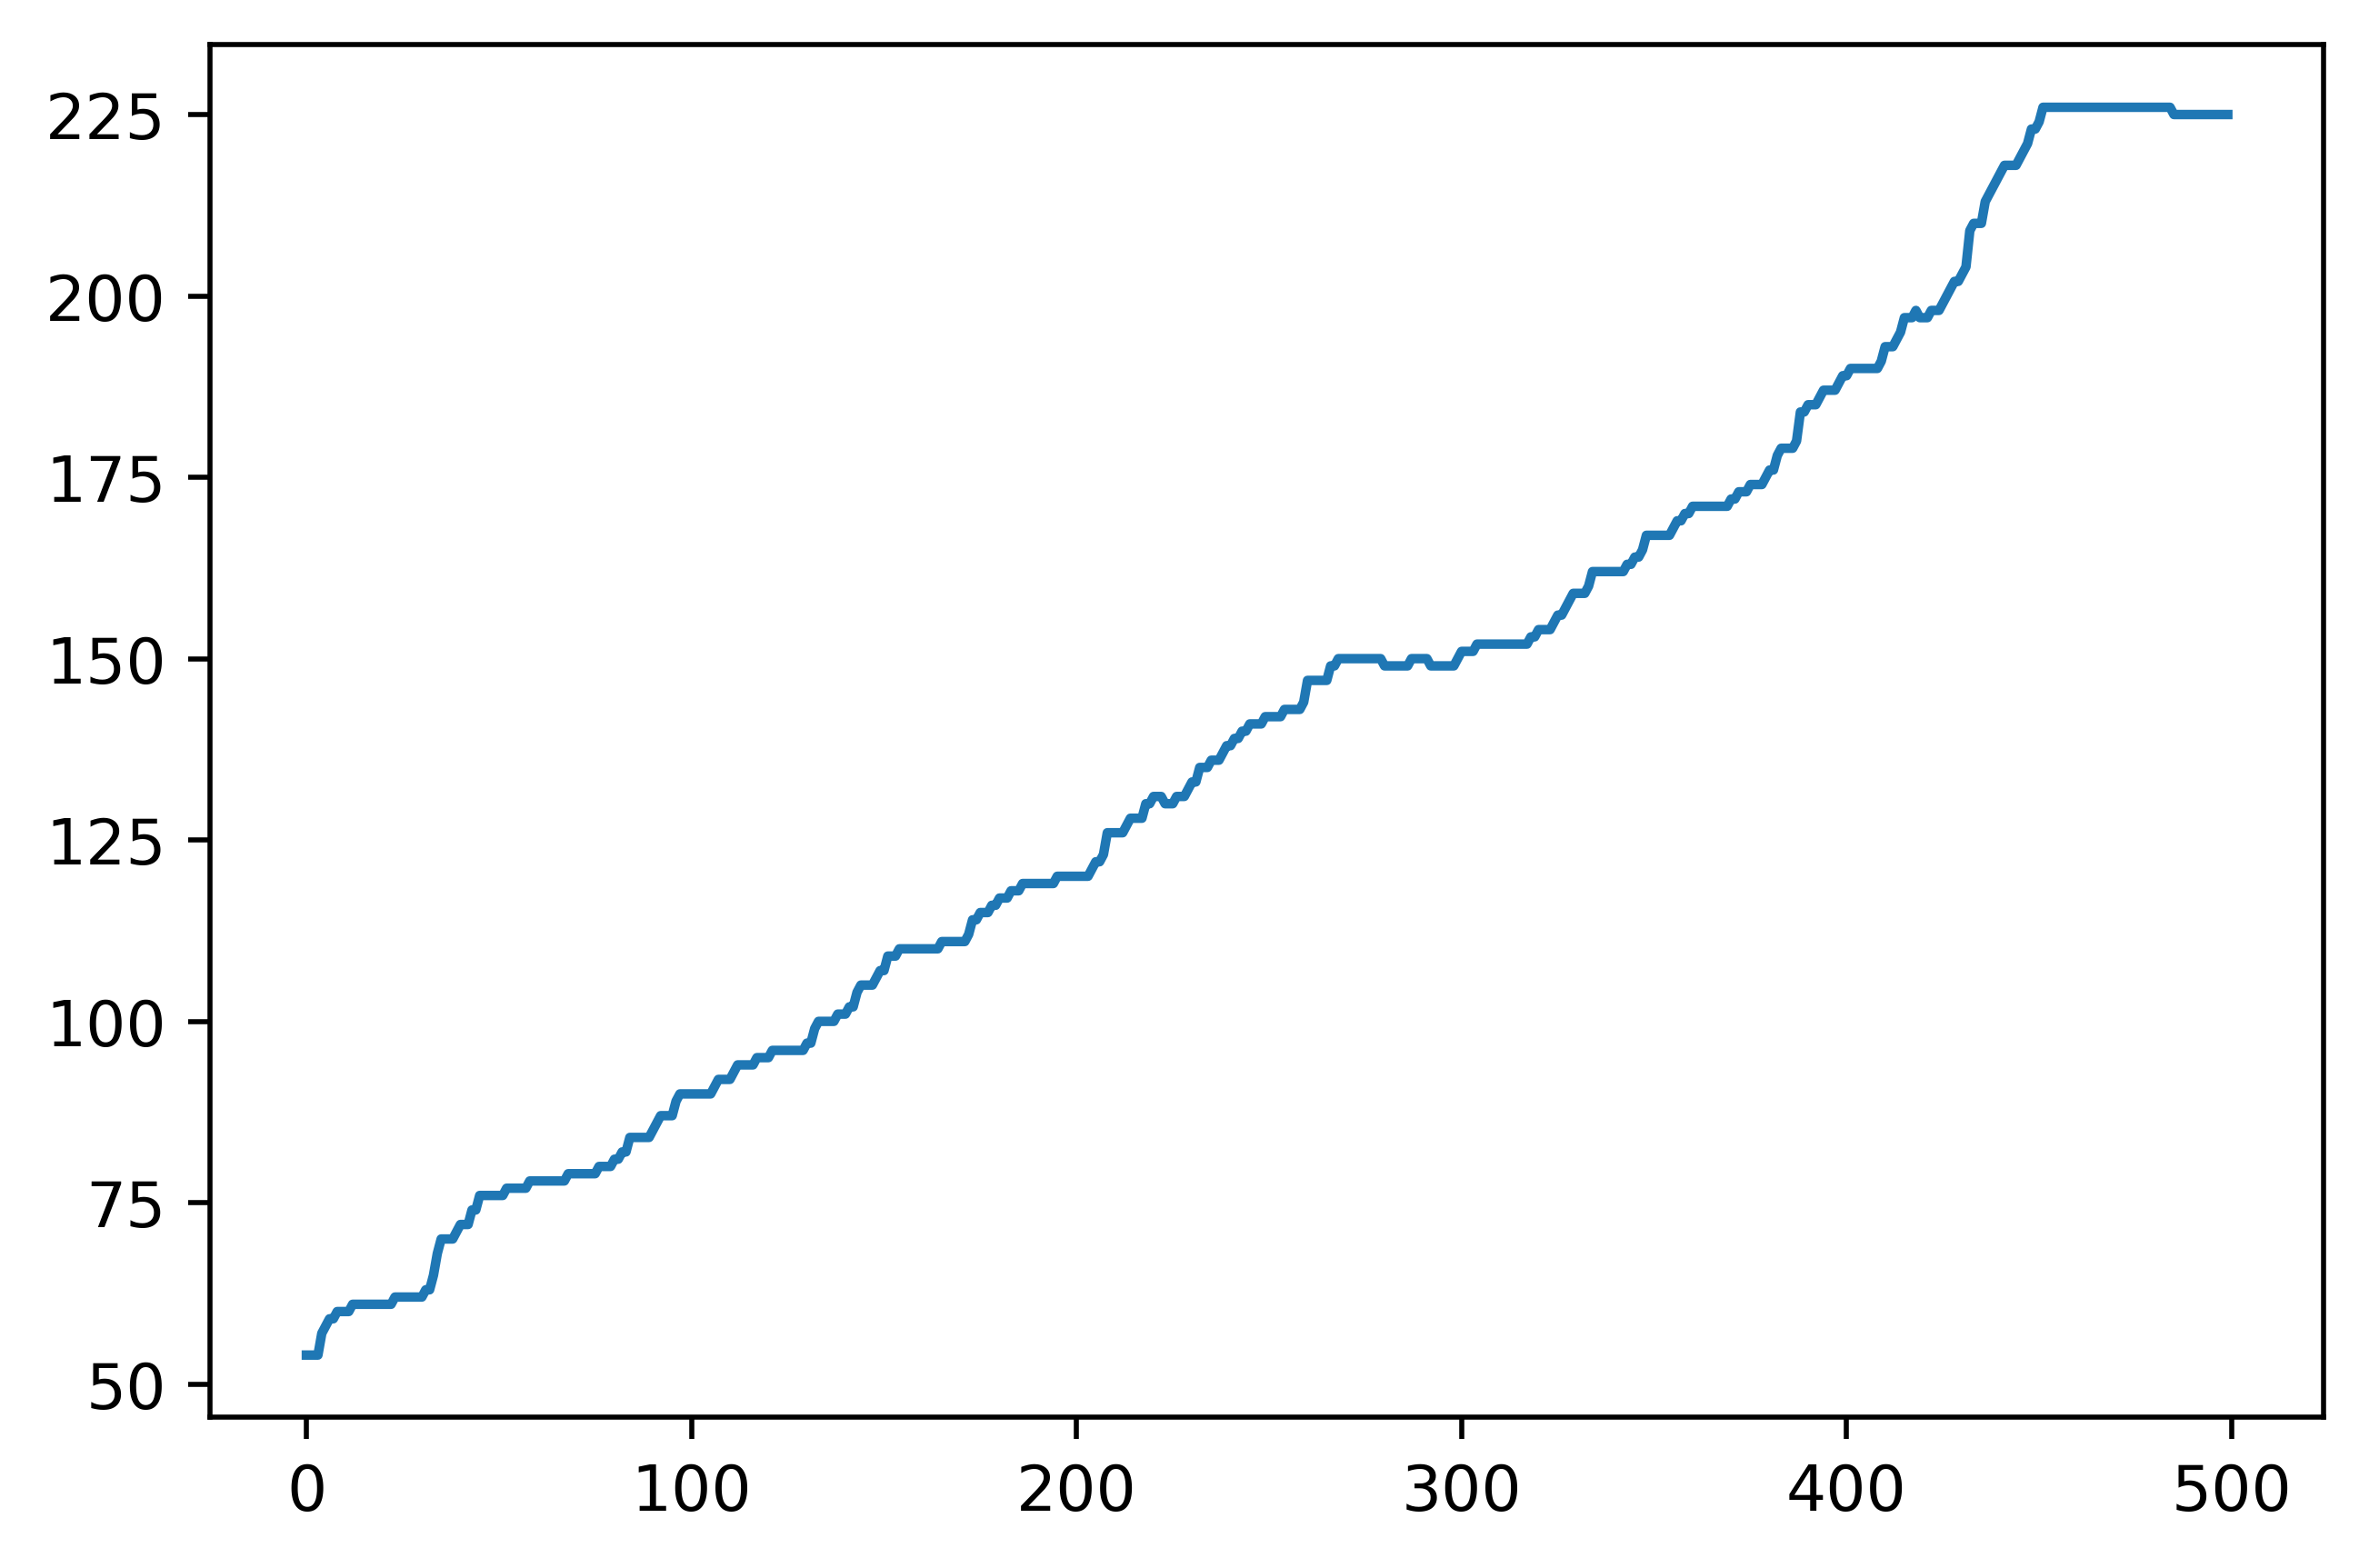

In [75]:
vertex = findVertex('video.avi')

# 保存为二进制文件
np.save('vertex2', vertex)

# 展示帧间有效点数的Demo
stride = 3
flags = []
for i in np.arange(1, 503 - stride + 1):
    id_ref = i
    id_img = i + stride
    flag = (np.sum(vertex[id_img - 1], axis = 1) >= 0) & (np.sum(vertex[id_ref - 1], axis = 1) >= 0)
    flags.append(sum(flag))

plt.rcParams['figure.dpi'] = 95
plt.plot(flags)

In [76]:
vertex = np.load('vertex2.npy')
displayVertex('video.avi', vertex, mode = 'debug')

In [352]:
def alignImg(vertex, ref, img, id_ref, id_img, fill = 1):
    '''
    :param vertex   :
    :param ref      :
    :param img      :
    :param :
    根据输入特征点计算单应性矩阵并对齐
    '''
    flag = (np.sum(vertex[id_img - 1], axis = 1) >= 0) & (np.sum(vertex[id_ref - 1], axis = 1) >= 0)
    p_img = vertex[id_img - 1][flag]
    p_ref = vertex[id_ref - 1][flag]

    # 计算单应性矩阵
    h, mask = cv2.findHomography(p_img, p_ref, cv2.RANSAC)
    # 变换
    height, width = img.shape[: 2]
    img_reg = cv2.warpPerspective(img, h, (width, height))

    if fill:
        ref_mb = cv2.medianBlur(ref, 21)
        img_reg = np.where(img_reg == 0, ref_mb, img_reg)

    
    vec = np.mean(p_img - p_ref, axis = 0)
    mag = np.sqrt(vec[0] ** 2 + vec[1] ** 2)

    return img_reg, mag

In [353]:
def alignImgD(vertex, ref, img, id_ref, id_img, fill = 1):
    '''
    :param vertex   :
    :param ref      :
    :param img      :
    :param :
    根据输入特征点，分左右两侧分别计算单应性矩阵并对齐
    '''
    flag = (np.sum(vertex[id_img - 1], axis = 1) >= 0) & (np.sum(vertex[id_ref - 1], axis = 1) >= 0)
    p_img = vertex[id_img - 1][flag]
    p_ref = vertex[id_ref - 1][flag]
    
    height, width = img.shape[: 2]
    th = width / 2

    flag1 = (p_img[:, 0] < th) & (p_ref[:, 0] < th)
    flag2 = (p_img[:, 0] >= th) & (p_ref[:, 0] >= th)

    #------------------------------

    p_img1 = p_img[flag1]
    p_ref1 = p_ref[flag1]

    # 计算单应性矩阵
    h1, mask1 = cv2.findHomography(p_img1, p_ref1, cv2.RANSAC)
    # 变换
    img_reg1 = cv2.warpPerspective(img, h1, (width, height))

    if fill:
        ref_mb1 = cv2.medianBlur(ref, 21)
        img_reg1 = np.where(img_reg1 == 0, ref_mb1, img_reg1)
    
    vec1 = np.mean(p_img1 - p_ref1, axis = 0)
    mag1 = np.sqrt(vec1[0] ** 2 + vec1[1] ** 2)

    #------------------------------

    p_img2 = p_img[flag2]
    p_ref2 = p_ref[flag2]

    # 计算单应性矩阵
    h2, mask2 = cv2.findHomography(p_img2, p_ref2, cv2.RANSAC)
    # 变换
    img_reg2 = cv2.warpPerspective(img, h2, (width, height))

    if fill:
        ref_mb2 = cv2.medianBlur(ref, 21)
        img_reg2 = np.where(img_reg2 == 0, ref_mb2, img_reg2)

    vec2 = np.mean(p_img2 - p_ref2, axis = 0)
    mag2 = np.sqrt(vec2[0] ** 2 + vec2[1] ** 2)

    mag = (mag1 + mag2) / 2
    img_reg = img_reg1.copy()
    img_reg[:, int(th): ] = img_reg2[:, int(th): ]

    return img_reg, mag

In [410]:
def alignImgC(vertex, ref, img, id_ref, id_img, fill = 1, p_th = 30):
    '''
    :param vertex   : 特征点
    :param ref      : 参照图像
    :param img      : 待处理图像
    :param id_ref   : 参照图象的id，从1开始数
    :param id_img   : 待处理图像的id，从1开始数
    :param fill     : 1表示用参照图象的中值滤波填充，0表示用白色填充
    :param p_th     : 取外沿特征点的数量（实际会稍大于p_th）
    根据输入特征点，从外沿向内取一定数量的点，
    计算单应性矩阵并对齐
    '''
    # 可用特征点
    flag = (np.sum(vertex[id_img - 1], axis = 1) >= 0) & (np.sum(vertex[id_ref - 1], axis = 1) >= 0)
    p_th = sum(flag) if sum(flag) < p_th else p_th
    p_img = vertex[id_img - 1][flag]
    p_ref = vertex[id_ref - 1][flag]

    # 计算平均移动距离
    vec = np.mean(p_img - p_ref, axis = 0)
    mag = np.sqrt(vec[0] ** 2 + vec[1] ** 2)

    # 从外沿向内取一定数量的点
    p_num = 0
    p_ref_conv = np.empty((0, 2))
    p_img_conv = np.empty((0, 2))

    while p_num < p_th:
        flag_conv = cv2.convexHull(p_ref.reshape(1, -1, 2).astype('int'), returnPoints = False).flatten()
        p_num += len(flag_conv)

        p_ref_conv = np.append(p_ref_conv, p_ref[flag_conv], axis = 0)
        p_img_conv = np.append(p_img_conv, p_img[flag_conv], axis = 0)

        deflag_conv = [i not in flag_conv for i in range(len(p_ref))]
        p_ref = p_ref[deflag_conv]
        p_img = p_img[deflag_conv]

    # 计算单应性矩阵
    # h, mask = cv2.findHomography(p_img_conv, p_ref_conv, cv2.RANSAC, ransacReprojThreshold = mag)
    h, mask = cv2.findHomography(p_img_conv, p_ref_conv, method = 0)
    # 变换
    height, width = img.shape[: 2]

    if fill:
        img_reg = cv2.warpPerspective(img, h, (width, height), flags = cv2.INTER_NEAREST)
        ref_mb = cv2.medianBlur(ref, 21)
        img_reg = np.where(img_reg == 0, ref_mb, img_reg)

    else:
        try:
            channel = img.shape[2]
        except:
            channel = 1
        img_reg = cv2.warpPerspective(img, h, (width, height), flags = cv2.INTER_NEAREST, borderValue = [255] * channel)

    return img_reg, mag

In [413]:
# alignC Demo
color = np.random.randint(0, 255, (1000, 3))

i = 251
stride = 3
ref = cv2.imread(f'frames/frame_{i}.jpg')
img = cv2.imread(f'frames/frame_{i + stride}.jpg')

id_ref = i
id_img = i + stride

flag = (np.sum(vertex[id_img - 1], axis = 1) >= 0) & (np.sum(vertex[id_ref - 1], axis = 1) >= 0)
p_img = vertex[id_img - 1][flag]
p_ref = vertex[id_ref - 1][flag]

p_th = 30
p_th = sum(flag) if sum(flag) < p_th else p_th
p_num = 0
p_ref_conv = np.empty((0, 2))
p_img_conv = np.empty((0, 2))

while p_num < p_th:
    flag_conv = cv2.convexHull(p_ref.reshape(1, -1, 2).astype('int'), returnPoints = False).flatten()
    p_num += len(flag_conv)

    p_ref_conv = np.append(p_ref_conv, p_ref[flag_conv], axis = 0)
    p_img_conv = np.append(p_img_conv, p_img[flag_conv], axis = 0)

    deflag_conv = [i not in flag_conv for i in range(len(p_ref))]
    p_ref = p_ref[deflag_conv]
    p_img = p_img[deflag_conv]

# 画点
for j, (new, old) in enumerate(zip(p_img_conv, p_ref_conv)):
    a, b = old.ravel().astype('int')
    c, d = new.ravel().astype('int')
    ref = cv2.circle(ref, (a, b), 5, color[j].tolist(), -1)
    img = cv2.circle(img, (c, d), 5, color[j].tolist(), -1)

img_shift, _ = alignImgC(vertex, ref, img, i, i + stride, fill = 1, p_th = p_th)

cv2.imshow('img', img)
cv2.imshow('ref', ref)
cv2.imshow('img_shift', img_shift)
cv2.moveWindow('img', 0, 0)
cv2.moveWindow('ref', 0, 0)
cv2.moveWindow('img_shift', 0, 0)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [291]:
# alignD Demo
i = 295
stride = 30
ref = cv2.imread(f'frames/frame_{i}.jpg')
img = cv2.imread(f'frames/frame_{i + stride}.jpg')

img_shift, _ = alignImgD(vertex, ref, img, i, i + stride, fill = 1)

cv2.imshow('img', img)
cv2.imshow('ref', ref)
cv2.imshow('img_shift', img_shift)
cv2.moveWindow('img', 0, 0)
cv2.moveWindow('ref', 0, 0)
cv2.moveWindow('img_shift', 0, 0)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [45]:
# align Demo
i = 16
stride = 3
ref = cv2.imread(f'frames/frame_{i}.jpg')
img = cv2.imread(f'frames/frame_{i + stride}.jpg')

img_shift, _ = alignImg(vertex, ref, img, i, i + stride, fill = 1)

cv2.imshow('img', img)
cv2.imshow('ref', ref)
cv2.imshow('img_shift', img_shift)
cv2.moveWindow('img', 0, 0)
cv2.moveWindow('ref', 0, 0)
cv2.moveWindow('img_shift', 0, 0)
cv2.waitKey(0)
cv2.destroyAllWindows()

0.10276579856872559


In [427]:
source = np.arange(-6, 7, 1)
source[np.argsort(np.abs(source))]

array([ 0, -1,  1, -2,  2, -3,  3, -4,  4, -5,  5, -6,  6])

In [486]:
a = np.array([1,2,3], dtype = 'uint8')
b = np.array([2,2,3], dtype = 'uint8')
cv2.subtract(b, a)

array([[1],
       [0],
       [0]], dtype=uint8)

In [32]:
help(cv2.imreadmodes

AttributeError: module 'cv2.cv2' has no attribute 'imreadmodes'

In [64]:
frame = cv2.imread('frames/frame_1.jpg')
frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
start = time()
# ret, mask1 = cv2.threshold(frame_hsv[..., 2], 100, 255, cv2.THRESH_BINARY_INV)
ret, mask2 = cv2.threshold(frame_hsv[..., 1], 80, 255, cv2.THRESH_BINARY)
# mask_hsv = cv2.bitwise_or(mask1, mask2)
print(time() - start)

cv2.imshow('mask_hsv', mask_hsv)
cv2.moveWindow('mask_hsv', 0, 0)
cv2.imshow('frame', frame)
cv2.moveWindow('frame', 0, 0)

cv2.waitKey(0)
cv2.destroyAllWindows()

0.0029926300048828125


In [102]:
imgs = []
for i in np.arange(1, 24, 1):
    start = time()
    img = cv2.imread(f'frames/frame_{i}.jpg')
    print(time() - start)
    imgs.append(img)

imgs = np.array(imgs)

img_avg = np.max(imgs, axis = 0).astype('uint8')

cv2.imshow('img_avg', img_avg)
cv2.waitKey(0)
cv2.destroyAllWindows()



0.01296377182006836
0.015990495681762695
0.017946958541870117
0.015929222106933594
0.016988277435302734
0.016956090927124023
0.017946243286132812
0.018950700759887695
0.01995396614074707
0.019908905029296875
0.018987655639648438
0.018950223922729492
0.01598978042602539
0.01597118377685547
0.017934083938598633
0.01794886589050293
0.018949270248413086
0.018950462341308594
0.017984867095947266
0.018941402435302734
0.01894998550415039
0.01897573471069336
0.02091693878173828
